In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE, simulate_for_sbi
from sbi import analysis
import torch

from sbi import utils as sbi_utils
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [3]:
# Configuration
num_samples = 100
t_max = 20
num_timesteps = 64
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

In [4]:
def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

In [5]:
# [WALL]--(k0,b0)--[m0]--(k1,b1)--[m1]--(k2,b2)--[m2]

# Define system of equations
def multi_mass_spring_damper(y, t, m, k, b, F_ext=None):
    """
    y: concatenated [x0, x1, ..., xn, v0, v1, ..., vn]
    m, k, b: arrays of length n
    F_ext: optional external force per mass at time t
    """
    n = len(m)
    x = y[:n]
    v = y[n:]
    
    dxdt = v
    dvdt = np.zeros(n)

    for i in range(n):
        # External force
        F = 0
        if F_ext is not None:
            F = np.interp(t, t_data, F_ext[i])

        # F = np.interp(t, t_data, x_data[0, :, 0])

        # Spring-damper forces from neighbors
        force = 0

        # Left spring/damper: wall or previous mass
        if i == 0: 
         force += -k[0] * x[0] - b[0] * v[0]  # connected to wall
        else:
            force += -k[i] * (x[i] - x[i-1]) - b[i] * (v[i] - v[i-1])

        # Right spring/damper: next mass if not last
        if i < n - 1:
            force += -k[i+1] * (x[i] - x[i+1]) - b[i+1] * (v[i] - v[i+1])

        dvdt[i] = (F + force) / m[i]

    return np.concatenate([dxdt, dvdt])


def multi_msd_simulator(params, F_ext=None):
    """
    params: [m0, m1, ..., k0, k1, ..., b0, b1, ...]
    """
    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return extract_summary_statistics_multimass(t, x, v)


def extract_summary_statistics_multimass(t, x, v):
    num_masses = x.shape[1]

    # Compute stats per mass
    stats = []
    for i in range(num_masses):
        stats.extend(extract_summary_statistics(t, x[:, i], v[:, i]))

    return np.array(stats)


def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats

def generate_deterministic_force(timesteps, seed=42, smoothing=2.0):
    rng = np.random.default_rng(seed)
    raw = rng.random(timesteps) - 0.5
    force = np.cumsum(raw)
    force = gaussian_filter1d(force, sigma=smoothing)
    return np.abs(force)

def simulator(params):
    # # Generate new force profile per sample
    
    # sample_idx = 0
    # F_shared = x_data[sample_idx, :, 0]
    # F_ext = np.tile(F_shared, (num_masses, 1))

    # Fixed random walk profile
    F_signal = generate_deterministic_force(num_timesteps)
    F_ext = np.tile(F_signal, (num_masses, 1)) 

    # F_ext = np.abs(np.cumsum(np.random.rand(num_masses, num_timesteps) - 0.5, axis=1))
    return multi_msd_simulator(params, F_ext=F_ext)


Running simulation for 2 masses


/tmp/ipykernel_11322/4247787527.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  m = np.array(params[:num_masses])
/tmp/ipykernel_11322/4247787527.py:48: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  k = np.array(params[num_masses:2*num_masses])
/tmp/ipykernel_11322/4247787527.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see t

Simulation time: 238.07 seconds
 Neural network successfully converged after 211 epochs.Training time: 201.22 seconds


Drawing 10000 posterior samples: 10349it [00:00, 68378.03it/s]                          


Inference time: 0.15 seconds

Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         2.4896     2.8030     12.59      0.3133    
m1         5.1834     4.7819     7.74       0.4014    
k0         8.1257     8.0930     0.40       0.0327    
k1         5.1858     5.0105     3.38       0.1753    
b0         5.9739     6.0817     1.81       0.1078    
b1         5.9009     6.8500     16.08      0.9491    
-------------------------------------------------------
MSE: 0.200592

Generating pairplot for 2 masses...


/tmp/ipykernel_11322/4247787527.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  m = np.array(params[:num_masses])
/tmp/ipykernel_11322/4247787527.py:48: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  k = np.array(params[num_masses:2*num_masses])
/tmp/ipykernel_11322/4247787527.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see t


Total time for 2 masses: 440.26 seconds

Running simulation for 3 masses


100%|██████████| 20000/20000 [05:56<00:00, 56.10it/s]


Simulation time: 356.54 seconds
 Neural network successfully converged after 371 epochs.Training time: 371.66 seconds


Drawing 10000 posterior samples: 11935it [00:00, 33668.94it/s]                          


Inference time: 0.36 seconds

Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         6.3437     3.6586     42.33      2.6851    
m1         2.5222     4.4736     77.37      1.9514    
m2         1.4380     0.8712     39.41      0.5668    
k0         2.7830     2.9158     4.77       0.1328    
k1         0.4370     0.7229     65.41      0.2858    
k2         4.9749     4.8525     2.46       0.1223    
b0         9.5209     8.8440     7.11       0.6769    
b1         6.5481     5.2816     19.34      1.2665    
b2         2.6035     3.8808     49.06      1.2772    
-------------------------------------------------------
MSE: 1.682973

Generating pairplot for 3 masses...

Total time for 3 masses: 729.35 seconds

Running simulation for 4 masses


 69%|██████▉   | 13844/20000 [05:29<02:26, 42.03it/s]


KeyboardInterrupt: 

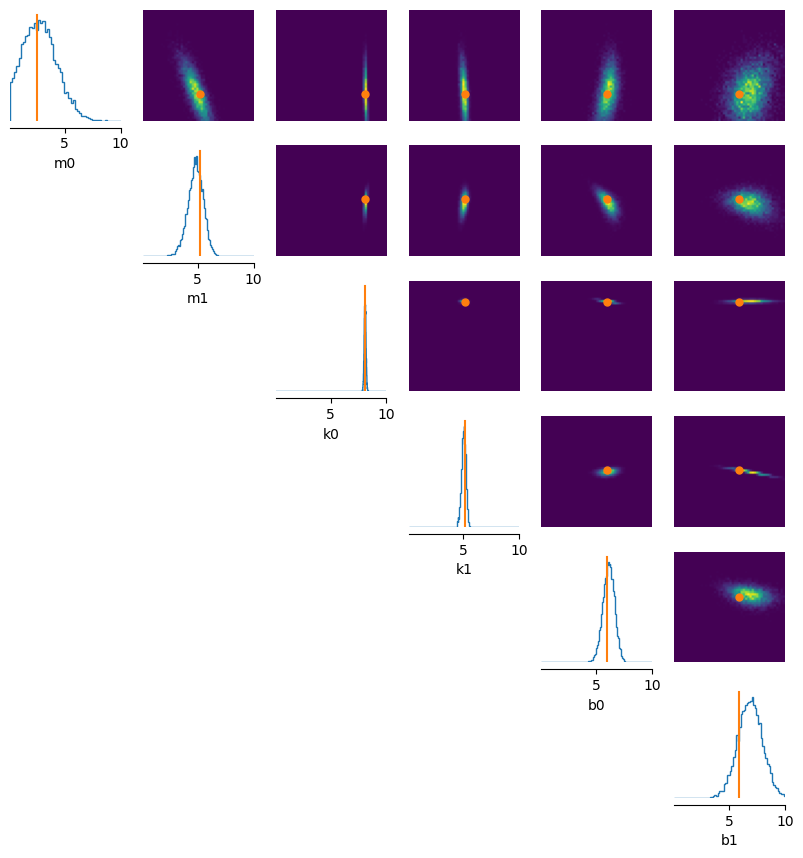

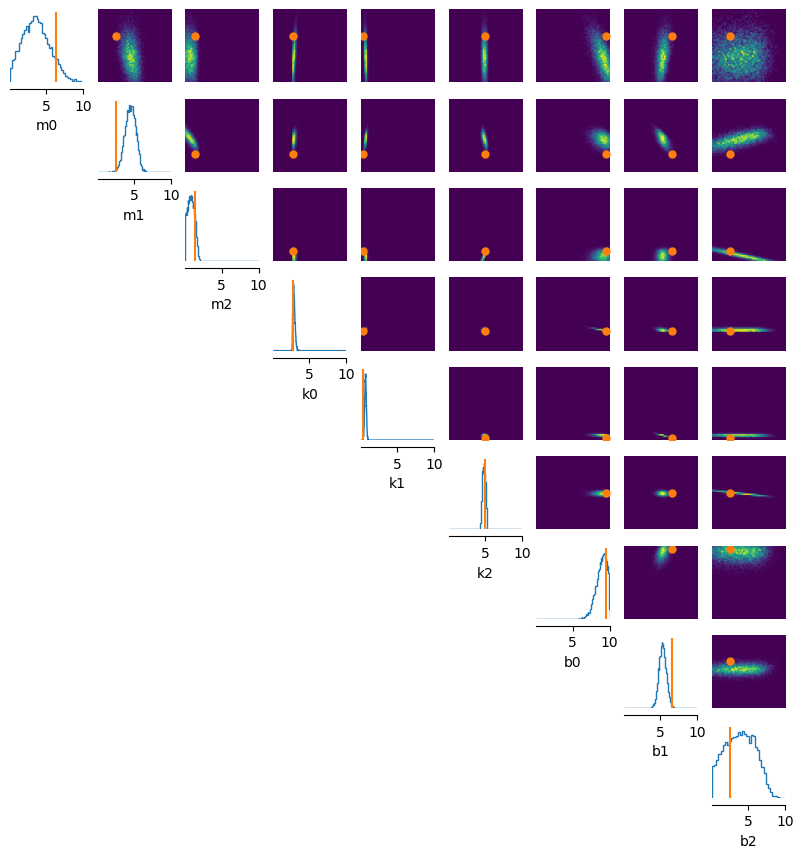

In [ ]:
import time
import numpy as np

# Prior distribution for (m, k, b) — for different number of masses

results = []

for num_masses in range(2, 5):  # 2, 3, 4 masses
    start_time = time.time()
    print(f"\n{'='*60}")
    print(f"Running simulation for {num_masses} masses")
    print(f"{'='*60}")
    
    num_simulations = 100000
    num_params = 3 * num_masses 

    # Set up the prior
    prior = sbi_utils.BoxUniform(
        low=torch.tensor([0.1] * num_params),
        high=torch.tensor([10.0] * num_params)
    )

    prior, num_parameters, prior_returns_numpy = process_prior(prior)

    simulator_wrapper = process_simulator(
        simulator,
        prior,
        prior_returns_numpy
    )

    check_sbi_inputs(simulator_wrapper, prior)

    # Create inference object
    inference = NPE(prior)

    # Simulation phase
    sim_start_time = time.time()
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
    sim_time = time.time() - sim_start_time
    print(f"Simulation time: {sim_time:.2f} seconds")

    # Training phase
    train_start_time = time.time()
    density_estimator = inference.append_simulations(theta, x).train()
    train_time = time.time() - train_start_time
    print(f"Training time: {train_time:.2f} seconds")

    # Build posterior
    posterior = inference.build_posterior(density_estimator)

    # Generate a sample from the prior for testing
    sample = prior.sample((1,))
    observed_data = simulator(sample.numpy()[0])
    observed_data = torch.tensor(observed_data, dtype=torch.float32)

    # Infer parameters
    inference_start_time = time.time()
    samples = posterior.sample((10000,), x=observed_data)
    inference_time = time.time() - inference_start_time
    print(f"Inference time: {inference_time:.2f} seconds")

    # Calculate mean of samples for each parameter
    mean_samples = torch.mean(samples, dim=0)

    # Print comparison between true and inferred parameters
    true_params, labels = get_param_labels_and_values(sample, num_masses)
    inferred_params, _ = get_param_labels_and_values(mean_samples, num_masses)

    # Calculate MSE and percentage errors
    mse = 0
    print(f"\n{'Parameter':<10} {'True':<10} {'Inferred':<10} {'% Error':<10} {'Abs Error':<10}")
    print("-" * 55)

    param_errors = []
    for i, label in enumerate(labels):
        pct_error = abs(true_params[i] - inferred_params[i]) / true_params[i] * 100
        abs_error = abs(true_params[i] - inferred_params[i])
        mse += (true_params[i] - inferred_params[i]) ** 2
        param_errors.append((label, true_params[i], inferred_params[i], pct_error, abs_error))
        print(f"{label:<10} {true_params[i]:<10.4f} {inferred_params[i]:<10.4f} {pct_error:<10.2f} {abs_error:<10.4f}")

    mse /= len(true_params)
    print("-" * 55)
    print(f"MSE: {mse:.6f}")
    
    # Create sample point from true parameters for plotting
    sample_point = sample.numpy()[0]

    # Generate pairplot
    print(f"\nGenerating pairplot for {num_masses} masses...")
    fig, ax = analysis.pairplot(
        samples,
        points=sample,
        labels=labels,
        limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
    )
    
    total_time = time.time() - start_time
    print(f"\nTotal time for {num_masses} masses: {total_time:.2f} seconds")
    
    # Store results for this run
    results.append({
        'num_masses': num_masses,
        'simulation_time': sim_time,
        'training_time': train_time,
        'inference_time': inference_time,
        'total_time': total_time,
        'mse': mse,
        'param_errors': param_errors,
        'posterior': posterior
    })

# Print summary of all runs
print("\n\n" + "="*80)
print("SUMMARY OF ALL RUNS")
print("="*80)
for result in results:
    print(f"\nResults for {result['num_masses']} masses:")
    print(f"Total time: {result['total_time']:.2f} seconds")
    print(f"Simulation time: {result['simulation_time']:.2f} seconds")
    print(f"Training time: {result['training_time']:.2f} seconds")
    print(f"Inference time: {result['inference_time']:.2f} seconds")
    print(f"MSE: {result['mse']:.6f}")

In [8]:
import pickle
import os

# Create a directory to save the posteriors if it doesn't exist
save_dir = "saved_posteriors"
os.makedirs(save_dir, exist_ok=True)

# Save each posterior from the results list
for i, result in enumerate(results):
    num_masses = result['num_masses']
    posterior = result['posterior']
    
    # Define the filename
    filename = f"{save_dir}/posterior_masses_{num_masses}.pkl"
    
    # Save the posterior using pickle
    with open(filename, 'wb') as f:
        pickle.dump(posterior, f)
    
    print(f"Saved posterior for {num_masses} masses to {filename}")

# Example of how to load a posterior back
# with open(f"{save_dir}/posterior_masses_2.pkl", 'rb') as f:
#     loaded_posterior = pickle.load(f)

Saved posterior for 2 masses to saved_posteriors/posterior_masses_2.pkl
Saved posterior for 3 masses to saved_posteriors/posterior_masses_3.pkl
Saved posterior for 4 masses to saved_posteriors/posterior_masses_4.pkl


In [8]:
import pickle
import os
import torch
import numpy as np
from sbi import analysis
from sbi.utils import BoxUniform

# Load saved posteriors and generate analysis for each one
import matplotlib.pyplot as plt

# Load saved posteriors
save_dir = "saved_posteriors"
posteriors = {}

# Get list of all pickle files in directory
posterior_files = [f for f in os.listdir(save_dir) if f.endswith('.pkl')]

# Load each posterior
for file in posterior_files:
    with open(os.path.join(save_dir, file), 'rb') as f:
        posterior = pickle.load(f)
        # Extract number of masses from filename
        num_masses = int(file.split('_')[-1].split('.')[0])
        posteriors[num_masses] = posterior

# Analysis for each posterior
analyzed_results = []

for num_masses, posterior in posteriors.items():
    print(f"\n{'='*60}")
    print(f"Analyzing posterior for {num_masses} masses")
    print(f"{'='*60}")
    
    # Set up the prior for this number of masses
    num_params = 3 * num_masses
    prior = BoxUniform(
        low=torch.tensor([0.1] * num_params),
        high=torch.tensor([10.0] * num_params)
    )
    
    # Sample from prior to generate "ground truth"
    sample = prior.sample((1,))
    
    # Run simulator with these parameters to get observation
    observed_data = simulator(sample.numpy()[0])
    observed_data = torch.tensor(observed_data, dtype=torch.float32)
    
    # Sample from posterior given this observation
    samples = posterior.sample((10000,), x=observed_data)
    
    # Calculate statistics of samples for each parameter
    mean_samples = torch.mean(samples, dim=0)
    median_samples = torch.median(samples, dim=0).values
    std_samples = torch.std(samples, dim=0)
    
    # Calculate confidence intervals (2.5% and 97.5%)
    ci_low = torch.quantile(samples, 0.025, dim=0)
    ci_high = torch.quantile(samples, 0.975, dim=0)
    
    # Generate parameter labels
    def get_param_labels_and_values(sample, num_masses):
        sample = sample.flatten()
        m = sample[:num_masses].tolist()
        k = sample[num_masses:2*num_masses].tolist()
        b = sample[2*num_masses:3*num_masses].tolist()
        params = m + k + b
        labels = [f"m{i}" for i in range(num_masses)] + \
                 [f"k{i}" for i in range(num_masses)] + \
                 [f"b{i}" for i in range(num_masses)]
        return params, labels
    
    # Get true parameters and labels
    true_params, labels = get_param_labels_and_values(sample, num_masses)
    
    # Calculate all statistics
    param_stats = []
    mse = 0
    
    # Header for the analytics table
    print(f"\n{'Parameter':<10} {'True':<10} {'Mean':<10} {'Median':<10} {'Std':<10} {'2.5% CI':<10} {'97.5% CI':<10} {'Abs. Error':<10} {'Rel. Error(%)':<12} {'MSE':<10}")
    print("-" * 110)
    
    for i, label in enumerate(labels):
        true_val = true_params[i]
        mean_val = mean_samples[i].item()
        median_val = median_samples[i].item()
        std_val = std_samples[i].item()
        ci_low_val = ci_low[i].item()
        ci_high_val = ci_high[i].item()
        
        abs_error = abs(true_val - mean_val)
        rel_error = (abs_error / true_val) * 100
        param_mse = (true_val - mean_val) ** 2
        
        mse += param_mse
        
        param_stats.append((
            label, true_val, mean_val, median_val, std_val, 
            ci_low_val, ci_high_val, abs_error, rel_error, param_mse
        ))
        
        print(f"{label:<10} {true_val:<10.4f} {mean_val:<10.4f} {median_val:<10.4f} {std_val:<10.4f} "
              f"{ci_low_val:<10.4f} {ci_high_val:<10.4f} {abs_error:<10.4f} {rel_error:<12.2f} {param_mse:<10.6f}")
        
        
    
    mse /= len(true_params)
    print("-" * 110)
    print(f"Overall MSE: {mse:.6f}")
    
    # Generate pairplot
    print(f"\nGenerating pairplot for {num_masses} masses...")
    fig, ax = analysis.pairplot(
        samples,
        points=sample,
        labels=labels,
        limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
    )
    plt.savefig(f"pairplot_masses_{num_masses}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    # Store results
    analyzed_results.append({
        'num_masses': num_masses,
        'mse': mse,
        'param_stats': param_stats,
        'true_params': true_params
    })

# Print summary of all analyses
print("\n\n" + "="*80)
print("SUMMARY OF ALL ANALYSES")
print("="*80)
for result in analyzed_results:
    print(f"\nResults for {result['num_masses']} masses:")
    print(f"MSE: {result['mse']:.6f}")
    print(f"Average absolute error: {np.mean([stat[7] for stat in result['param_stats']]):.4f}")
    print(f"Average relative error: {np.mean([stat[8] for stat in result['param_stats']]):.2f}%")



Analyzing posterior for 4 masses


Drawing 10000 posterior samples: 10141it [00:02, 4592.45it/s]                          



Parameter  True       Mean       Median     Std        2.5% CI    97.5% CI   Abs. Error Rel. Error(%) MSE       
--------------------------------------------------------------------------------------------------------------
m0         0.1796     1.1985     0.9818     0.8974     0.1317     3.3836     1.0189     567.26       1.038089  
m1         2.3302     1.2132     1.0824     0.7855     0.1517     3.0406     1.1171     47.94        1.247805  
m2         1.8501     1.7536     1.7134     0.8486     0.2695     3.5084     0.0965     5.21         0.009304  
m3         1.4839     1.5358     1.5425     0.3862     0.7569     2.2615     0.0519     3.50         0.002696  
k0         6.3358     6.0694     6.0681     0.1975     5.6937     6.4702     0.2665     4.21         0.071004  
k1         4.3997     4.1490     4.1430     0.1576     3.8550     4.4666     0.2506     5.70         0.062809  
k2         8.9790     9.0752     9.0521     0.2877     8.5719     9.6993     0.0962     1.07         0.

Drawing 10000 posterior samples: 11235it [00:00, 87613.66it/s]            


Parameter  True       Mean       Median     Std        2.5% CI    97.5% CI   Abs. Error Rel. Error(%) MSE       
--------------------------------------------------------------------------------------------------------------
m0         0.8385     1.9672     1.8335     1.1553     0.2068     4.5179     1.1287     134.61       1.273942  
m1         2.4786     1.9082     1.9399     0.6933     0.4794     3.0905     0.5704     23.01        0.325349  
k0         0.2789     0.3176     0.3128     0.0407     0.2495     0.4125     0.0387     13.86        0.001495  
k1         8.9237     9.2570     9.2722     0.3440     8.5549     9.8694     0.3333     3.74         0.111093  
b0         3.3716     3.1775     3.2059     0.2083     2.6857     3.5047     0.1941     5.76         0.037672  
b1         8.4719     5.3733     5.3543     2.1000     1.2942     9.3691     3.0986     36.58        9.601422  
-------------------------------------------------------------------------------------------------------


Analyzing posterior for 3 masses


Drawing 10000 posterior samples:  10%|█         | 1005/10000 [00:13<02:03, 72.61it/s]WARNING:root:Only 0.086% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    8995 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 10000 posterior samples: 10002it [02:19, 71.71it/s]                           



Parameter  True       Mean       Median     Std        2.5% CI    97.5% CI   Abs. Error Rel. Error(%) MSE       
--------------------------------------------------------------------------------------------------------------
m0         5.2808     3.7090     3.4321     2.2933     0.2929     8.7500     1.5718     29.76        2.470577  
m1         5.4048     6.9839     7.0077     1.0741     4.8647     9.0118     1.5791     29.22        2.493592  
m2         4.9751     4.9888     4.9909     0.1750     4.6352     5.3234     0.0137     0.28         0.000189  
k0         8.7534     9.2110     9.2105     0.2505     8.7233     9.7083     0.4576     5.23         0.209389  
k1         5.5504     5.7075     5.7152     0.1891     5.3180     6.0439     0.1571     2.83         0.024665  
k2         1.2050     1.1801     1.1849     0.0491     1.0714     1.2640     0.0249     2.06         0.000619  
b0         8.6874     6.9975     7.0373     1.2123     4.4768     9.2747     1.6899     19.45        2.

/tmp/ipykernel_38101/4247787527.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  m = np.array(params[:num_masses])
/tmp/ipykernel_38101/4247787527.py:48: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  k = np.array(params[num_masses:2*num_masses])
/tmp/ipykernel_38101/4247787527.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see t

 Neural network successfully converged after 256 epochs.

Drawing 100000 posterior samples: 100099it [00:00, 253726.40it/s]                           


Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         6.2096     5.9718     3.83       0.2378    
k0         6.4789     6.2564     3.43       0.2225    
b0         3.3579     3.6864     9.78       0.3285    
-------------------------------------------------------
MSE: 0.071347


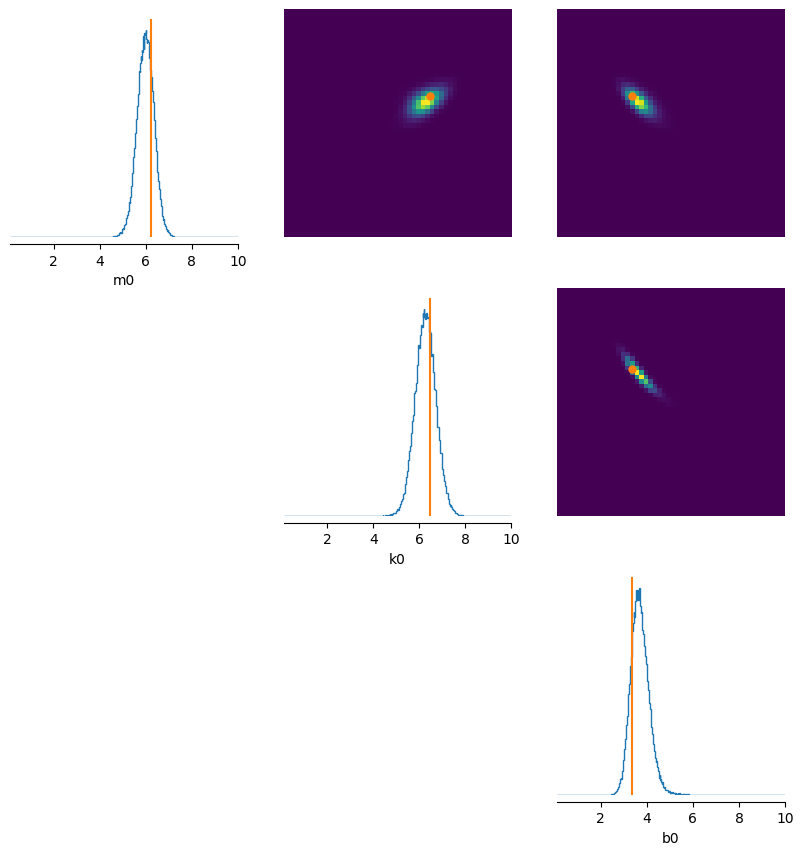

In [30]:
# Prior distribution for (m, k, b) — assuming you know rough ranges
num_masses = 1
num_simulations = 100

num_params = 3 * num_masses 

prior = sbi_utils.BoxUniform(
    low=torch.tensor([0.1] * num_params),
    high=torch.tensor([10.0] * num_params)
)

prior, num_parameters, prior_returns_numpy = process_prior(prior)

simulator_wrapper = process_simulator(
    simulator,
    prior,
    prior_returns_numpy
)

check_sbi_inputs(simulator_wrapper, prior)

# Create inference object
inference = NPE(prior)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)

# Train the inference network
density_estimator = inference.append_simulations(theta, x).train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

sample = prior.sample((1,))
observed_data = simulator(sample.numpy()[0])
observed_data = torch.tensor(observed_data, dtype=torch.float32)

# Infer parameters
samples = posterior.sample((100000,), x=observed_data)

# Calculate mean of samples for each parameter
mean_samples = torch.mean(samples, dim=0)

# Print comparison between true and inferred parameters
true_params, labels = get_param_labels_and_values(sample, num_masses)
inferred_params, _ = get_param_labels_and_values(mean_samples, num_masses)

# Calculate MSE and percentage errors
mse = 0
print(f"{'Parameter':<10} {'True':<10} {'Inferred':<10} {'% Error':<10} {'Abs Error':<10}")
print("-" * 55)

for i, label in enumerate(labels):
    pct_error = abs(true_params[i] - inferred_params[i]) / true_params[i] * 100
    abs_error = abs(true_params[i] - inferred_params[i])
    mse += (true_params[i] - inferred_params[i]) ** 2
    
    print(f"{label:<10} {true_params[i]:<10.4f} {inferred_params[i]:<10.4f} {pct_error:<10.2f} {abs_error:<10.4f}")

mse /= len(true_params)
print("-" * 55)
print(f"MSE: {mse:.6f}")

# Create sample point from true parameters for plotting
sample_point = sample.numpy()[0]

fig, ax = analysis.pairplot(
    samples,
    points=sample,
    labels=labels,
    limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
)